In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [13]:
df = df_ = pd.read_csv(filepath_or_buffer="C:\\Lib\\fifa_players.csv")
df = df_.copy()

In [14]:
from sklearn.preprocessing import LabelEncoder
df = df.drop(columns=['full_name','name','birth_date','nationality'])

categorical_to_nums = {'preferred_foot'  :   {'Left'  : 0, 'Right' : 1,},
                       'body_type'  :   {'Lean'  : 0, 'Normal' : 1, 'Stocky' : 2}} 
for column, mapping in categorical_to_nums.items():
    temp_series = df[column].copy()
    null_mask = temp_series.isnull()
    temp_series.loc[~null_mask] = temp_series.loc[~null_mask].map(mapping) 
    df[column] = temp_series.fillna(-1).astype('int64')

df['positions'] = df['positions'].str.split(',').str[0]   


for column in ['height_cm','value_euro','wage_euro','release_clause_euro' ]:   
    df[column] = df.groupby('positions')[column].transform(lambda x: x.fillna(x.median()))
    
    
    
df = df.drop(columns=['national_team','national_team_position','national_jersey_number','national_rating'])


encoder = LabelEncoder()

df['positions_encoded'] = encoder.fit_transform(df['positions'])


df = df.drop(columns=['positions'])

C:\Users\redoe\AppData\Local\Temp\ipykernel_4196\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')
C:\Users\redoe\AppData\Local\Temp\ipykernel_4196\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')


In [15]:
X = df.drop(columns=['value_euro'])


y = df['value_euro']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.20)

In [16]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X,y)
mutual_info = pd.Series(mutual_info, index=X.columns)

In [17]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)
selected_top_columns.fit(X_train,y_train)

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_regression at 0x000001CA763DC720>)

In [18]:
X_train = pd.DataFrame(selected_top_columns.transform(X_train), 
                     columns=X_train.columns[selected_top_columns.get_support()], 
                     index=X_train.index)

X_test = pd.DataFrame(selected_top_columns.transform(X_test), 
                    columns=X_test.columns[selected_top_columns.get_support()], 
                    index=X_test.index)

In [19]:
def shorten_number(x, pos):
    if x >= 1_000_000_000:
        return f'{x / 1_000_000_000:.2f}B'  # Milyar
    elif x >= 1_000_000:
        return f'{x / 1_000_000:.2f}M'  # Milyon
    elif x >= 1_000:
        return f'{x / 1_000:.2f}K'  # Bin
    else:
        return str(x)

C:\Users\redoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
8 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\redoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\redoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packa

BEST:  {'n_neighbors': 5}


C:\Users\redoe\AppData\Local\Temp\ipykernel_4196\977373225.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(y_test,best_knn_pred_abs,'ro',color='red', markerfacecolor='red',markersize='1')


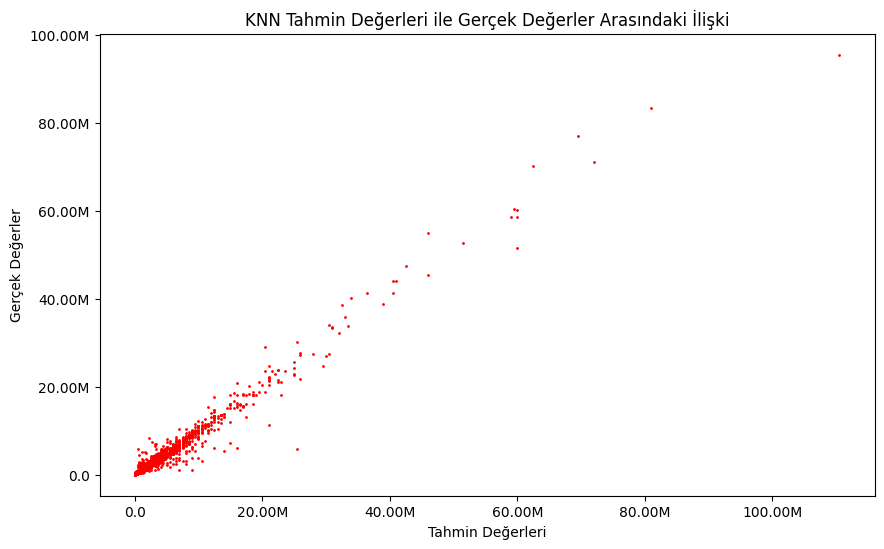

{'Mean Squared Error': 868209671122.2501, 'Root Mean Squared Error': 931777.6940463053, 'Mean Absolute Error': 321074.0740740741, 'Cross Validation': array([0.95682152, 0.96965152, 0.96939858, 0.96179961, 0.9818423 ,
       0.96747318, 0.96763014, 0.96512563, 0.98008423, 0.91997788]), 'R2 Score': 0.9731708693607352}


In [20]:
# KNN
# En iyi K değerinin belirlenmesi
params = {'n_neighbors' : range(40)}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=8)
model.fit(X_train,y_train)
print("BEST: ",model.best_params_)

# Belirlenen en iyi K değeri için KNN algoritmasının oluşturulması
best_knn = KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
#best_knn = KNeighborsRegressor(n_neighbors=5)
best_knn.fit(X_train, y_train)
best_knn_pred = best_knn.predict(X_test)
best_knn_pred_abs = abs(best_knn_pred)
    
    
    
best_knn_score_train = best_knn.score(X_train, y_train)
best_knn_score_test = best_knn.score(X_test, y_test)
    
mse = mean_squared_error(y_test, best_knn_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, best_knn_pred)
cross_val = cross_val_score(best_knn, X_train, y_train, cv=10)
r2 = r2_score(y_test, best_knn_pred)
knn_best_values = {'Mean Squared Error'       :   mse,
                     'Root Mean Squared Error'  :   rmse,
                     'Mean Absolute Error'      :   mae,
                     'Cross Validation'         :   cross_val,
                     'R2 Score'                 :   r2}
plt.figure(figsize=(10,6))
plt.plot(y_test,best_knn_pred_abs,'ro',color='red', markerfacecolor='red',markersize='1')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
plt.title("KNN Tahmin Değerleri ile Gerçek Değerler Arasındaki İlişki")
plt.xlabel("Tahmin Değerleri")
plt.ylabel("Gerçek Değerler")
plt.show()

print(knn_best_values)

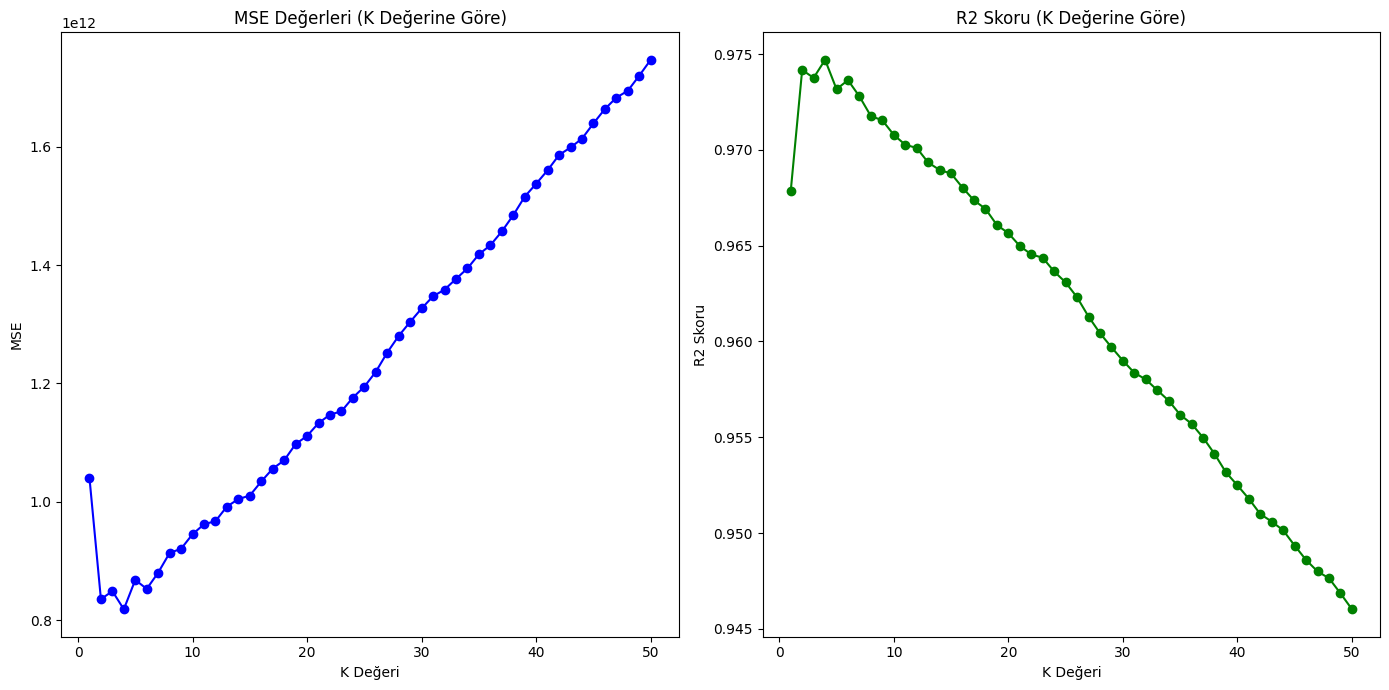

In [21]:
k_values = range(1, 51)
mse_values = []
r2_values = []

# Her K değeri için modelin eğitilmesi ve performansın ölçülmesi
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    
    mse = mean_squared_error(y_test, knn_pred)  # MSE hesapla
    r2 = r2_score(y_test, knn_pred)  # R2 skorunu hesapla
    
    mse_values.append(mse)  # MSE değerini listeye ekle
    r2_values.append(r2)    # R2 değerini listeye ekle

# MSE ve R2 skorlarının grafiğini çizme
plt.figure(figsize=(14, 7))

# MSE Grafiği
plt.subplot(1, 2, 1)
plt.plot(k_values, mse_values, marker='o', color='blue')
plt.title('MSE Değerleri (K Değerine Göre)')
plt.xlabel('K Değeri')
plt.ylabel('MSE')

# R2 Skoru Grafiği
plt.subplot(1, 2, 2)
plt.plot(k_values, r2_values, marker='o', color='green')
plt.title('R2 Skoru (K Değerine Göre)')
plt.xlabel('K Değeri')
plt.ylabel('R2 Skoru')

plt.tight_layout()
plt.show()